In [1]:
import pandas as pd
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt

In [2]:
file = "kicking/player_stats_kicking_2021.csv.gz"
df = pd.read_csv(file, compression='gzip', error_bad_lines=False)
df.head(10)
# Note: data is broken down by week for each kicker

,season,week,season_type,team,player_name,player_id,fg_made,fg_missed,fg_blocked,fg_long,fg_att,fg_pct,pat_made,pat_missed,pat_blocked,pat_att,pat_pct,fg_made_distance,fg_missed_distance,fg_blocked_distance,gwfg_att,gwfg_distance,gwfg_made,gwfg_missed,gwfg_blocked,fg_made_0_19,fg_made_20_29,fg_made_30_39,fg_made_40_49,fg_made_50_59,fg_made_60_,fg_missed_0_19,fg_missed_20_29,fg_missed_30_39,fg_missed_40_49,fg_missed_50_59,fg_missed_60_,fg_made_list,fg_missed_list,fg_blocked_list
0,2021,1,REG,ARI,M.Prater,00-0023853,1,1,0,34,2,0.5,5,0,0,5,1.000,34,43,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,34,43,NaN
1,2021,1,REG,ATL,Y.Koo,00-0033702,2,0,0,27,2,1.0,0,0,0,0,NaN,48,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,21;27,NaN,NaN
2,2021,1,REG,BAL,J.Tucker,00-0029597,2,0,0,47,2,1.0,3,0,0,3,1.000,87,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,40;47,NaN,NaN
3,2021,1,REG,BUF,T.Bass,00-0036162,3,0,0,42,3,1.0,1,0,0,1,1.000,104,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,37;25;42,NaN,NaN
4,2021,1,REG,CAR,R.Santoso,00-0034648,2,0,0,29,2,1.0,1,1,0,2,0.500,51,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,22;29,NaN,NaN
5,2021,1,REG,CHI,C.Santos,00-0031203,0,0,0,0,0,NaN,2,0,0,2,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
6,2021,1,REG,CIN,E.McPherson,00-0036854,2,0,0,53,2,1.0,3,0,0,3,1.000,86,0,0,1,33,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,53;33,NaN,NaN
7,2021,1,REG,CLE,C.McLaughlin,00-0035358,0,0,0,0,0,NaN,3,0,0,3,1.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
8,2021,1,REG,DAL,G.Zuerlein,00-0029621,3,2,0,48,5,0.6,2,1,0,3,0.667,104,91,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,1,35;21;48,31;60,NaN
9,2021,1,REG,DEN,B.McManus,00-0029822,2,0,0,36,2,1.0,3,0,0,3,1.000,59,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,23;36,NaN,NaN


In [3]:
# chceking NaN from data
tester = df.loc[0, "fg_blocked_list"]
print(tester)
print(type(tester))
print(pd.isna(tester))

nan
<class 'float'>
True


## Functions to correct fg_lists 
currently ["21;27"] - change to [21, 27]

In [4]:
def correct_list(df_col):
    if pd.isna(df_col):
        return []
    else:
        split_list = df_col.split(";")
        return [int(x) for x in split_list]

In [5]:
# BEFORE
df.loc[8, ["fg_made_list", "fg_missed_list", "fg_blocked_list"]]

fg_made_list       35;21;48
fg_missed_list        31;60
fg_blocked_list         NaN
Name: 8, dtype: object

In [6]:
df["fg_made_list"] = df["fg_made_list"].apply(correct_list)
df["fg_missed_list"] = df["fg_missed_list"].apply(correct_list)
df["fg_blocked_list"] = df["fg_blocked_list"].apply(correct_list)

In [7]:
# AFTER
df.loc[8, ["fg_made_list", "fg_missed_list", "fg_blocked_list"]]

fg_made_list       [35, 21, 48]
fg_missed_list         [31, 60]
fg_blocked_list              []
Name: 8, dtype: object

## Function to calculate season average for field goals from all distances

In [8]:
def calculate_basic_average(df):
    made = df["fg_made"].sum()
    attempted = df["fg_att"].sum()
    return round(100*made/(attempted), 1)

In [9]:
basic_average = calculate_basic_average(df)
print(f"The overall average for field goals was: {basic_average}%")

The overall average for field goals was: 85.3%


## Look at extra point conversion (calculate expected value)

In [10]:
made_xp = df["pat_made"].sum()
attempted_xp = df["pat_att"].sum()
xp_perc = round(made_xp/attempted_xp, 4)
print(f"There were {attempted_xp} attempted extra points and {made_xp} were made for a percent of {round(100*xp_perc,2)}%")

There were 1317 attempted extra points and 1231 were made for a percent of 93.47%


## Function to collect data for each fg distance

In [11]:
def make_fg_by_yard_dict(df):
    # dictionary to hold [attempts, makes] for each distance tried
    fg_dict = {}
    
    # check each row for made kicks, missed kicks, blocked kicks
    for row in range(len(df)):
        made_list = df.loc[row, "fg_made_list"]
        if len(made_list) > 0:
            # go through each made kick
            for j in range(len(made_list)):
                # if the yard distance is in fg_dict add an attempt and make 
                if fg_dict.get(int(made_list[j])) is not None:
                    fg_dict[int(made_list[j])][0] += 1
                    fg_dict[int(made_list[j])][1] += 1
                # otherwise create key with value of 1 make and 1 attempt
                else:
                    fg_dict[int(made_list[j])] = [1,1]
                    
        
        missed_list = df.loc[row, "fg_missed_list"]
        if len(missed_list) > 0:
            for j in range(len(missed_list)):
                if fg_dict.get(int(missed_list[j])) is not None:
                    fg_dict[int(missed_list[j])][0] += 1
                else:
                    fg_dict[int(missed_list[j])] = [1,0]
                    
        blocked_list = df.loc[row, "fg_blocked_list"]
        if len(blocked_list) > 0:
            for j in range(len(blocked_list)):
                if fg_dict.get(int(blocked_list[j])) is not None:
                    fg_dict[int(blocked_list[j])][0] += 1
                else:
                    fg_dict[int(blocked_list[j])] = [1,0]
                    
    return(fg_dict) 

### Create dictionary and convert to percent, then sort by yards

In [12]:
data_dict = make_fg_by_yard_dict(df)

fg_perc_dict = {}
for distance in data_dict:
    attempts = data_dict[distance][0]
    made = data_dict[distance][1]
    fg_perc_dict[distance] = round(100*made/attempts, 2)

sorted_fg_perc_dict = dict(sorted(fg_perc_dict.items(), key=lambda item: item[0]))
sorted_fg_perc_dict

{19: 100.0,
 20: 100.0,
 21: 100.0,
 22: 96.0,
 23: 100.0,
 24: 100.0,
 25: 95.65,
 26: 100.0,
 27: 100.0,
 28: 100.0,
 29: 100.0,
 30: 100.0,
 31: 97.3,
 32: 91.3,
 33: 96.3,
 34: 93.94,
 35: 90.62,
 36: 85.0,
 37: 91.67,
 38: 100.0,
 39: 87.5,
 40: 87.1,
 41: 79.31,
 42: 70.0,
 43: 84.62,
 44: 80.77,
 45: 79.31,
 46: 80.49,
 47: 62.96,
 48: 82.93,
 49: 64.0,
 50: 73.68,
 51: 63.33,
 52: 81.08,
 53: 67.65,
 54: 72.22,
 55: 68.42,
 56: 46.15,
 57: 50.0,
 58: 50.0,
 59: 0.0,
 60: 0.0,
 61: 66.67,
 62: 100.0,
 65: 0.0,
 66: 100.0,
 68: 0.0}

## Plot fg accuracy by distance with horizontal line for basic average

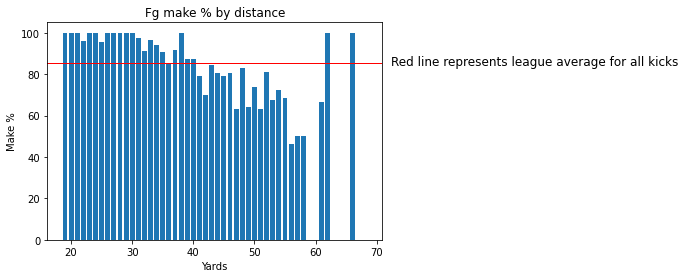

In [13]:
plt.bar(x=list(sorted_fg_perc_dict.keys()), height=list(sorted_fg_perc_dict.values()))
plt.axhline(y=basic_average, linewidth=1, color='r')
plt.title("Fg make % by distance")
plt.xlabel("Yards")
plt.ylabel("Make %")
# get current figure and place text outside of plot
plt.gcf().text(0.92, 0.73, "Red line represents league average for all kicks", fontsize=12)
None

## Make a bet for each kick and see which teams would have made money based on 2021 kicks

In [14]:
def ave_vs_league_ave(fg_dict, df, comp_type):
    # key: fg distance, value: payout
    payout_dict = {}
    wager = 10
    for distance in fg_dict:
        made = fg_dict[distance][1]
        missed = fg_dict[distance][0] - made
        if(made > 0):
            payout = (missed/made)*wager
            payout_dict[distance] = payout
    
    data_dict = {}
    if comp_type == "team":
        teams = list(df["team"].unique())
        for i in range(len(teams)):
            data_dict[teams[i]] = 0
            
    elif comp_type == "player_name":
        players = list(df["player_name"].unique())
        for i in range(len(players)):
            data_dict[players[i]] = 0
    else:
        print(f"ave_type must be 'team' or 'player_name'. '{ave_type}' is not one of them ")
        return
    
    # go through each row and make bets for each kick and add/subtract total from team's total
    for row in range(len(df)):
        # access list of made kicks
        made_kicks = df.loc[row, "fg_made_list"]  
        # if list is not empty
        if len(made_kicks) > 0:
            row_data = df.loc[row, comp_type]
            for j in range(len(made_kicks)):
                data_dict[row_data] += payout_dict[int(made_kicks[j])]
    
        missed_kicks = df.loc[row, "fg_missed_list"]  
        if len(missed_kicks) > 0:
            row_data = df.loc[row, comp_type]
            for j in range(len(missed_kicks)):
                data_dict[row_data] -= wager
                
        # add blocked kicks here
        blocked_kicks = df.loc[row, "fg_blocked_list"]
        if len(blocked_kicks) > 0:
            row_data = df.loc[row, comp_type]
            for j in range(len(blocked_kicks)):
                data_dict[row_data] -= wager
            
    # round winnings
    for key in data_dict:
        data_dict[key] = round(data_dict[key], 2) 
        
    return(data_dict)

In [15]:
team_betting_dict = ave_vs_league_ave(data_dict, df, "team")

sorted_team_betting_dict = dict(sorted(team_betting_dict.items(), key=lambda item: item[1], reverse=True))
sorted_team_betting_dict

{'LV': 49.35,
 'BAL': 44.22,
 'CIN': 34.02,
 'CAR': 28.15,
 'PIT': 27.86,
 'NE': 26.19,
 'NYG': 23.41,
 'LA': 20.8,
 'PHI': 18.75,
 'ATL': 17.65,
 'KC': 17.12,
 'SF': 15.45,
 'DET': 9.25,
 'DEN': 6.92,
 'MIN': 3.76,
 'LAC': -4.44,
 'CHI': -5.66,
 'DAL': -9.08,
 'BUF': -9.69,
 'WAS': -10.03,
 'ARI': -15.41,
 'IND': -17.97,
 'HOU': -23.25,
 'JAX': -23.45,
 'NO': -23.72,
 'TEN': -24.36,
 'NYJ': -26.33,
 'CLE': -29.42,
 'SEA': -31.81,
 'TB': -42.18,
 'MIA': -44.11,
 'GB': -62.01}

In [16]:
sum(team_betting_dict.values())
# some kicks do not have any payouts due to no misses

-60.01999999999998

### Plot teams' profits/losses

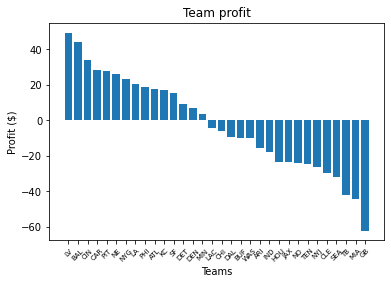

In [17]:
plt.bar(x=list(sorted_team_betting_dict.keys()), height=list(sorted_team_betting_dict.values()))
plt.title("Team profit")
plt.xlabel("Teams")
plt.ylabel("Profit ($)")
plt.xticks(rotation=45, fontsize=7)
None

## Make a bet for each kick and see which kickers would have made money

In [18]:
player_betting_dict = ave_vs_league_ave(data_dict, df, "player_name")

sorted_player_betting_dict = dict(sorted(player_betting_dict.items(), key=lambda item: item[1], reverse=True))
sorted_player_betting_dict

{'D.Carlson': 49.35,
 'J.Tucker': 44.22,
 'Z.Gonzalez': 35.74,
 'E.McPherson': 32.26,
 'C.Boswell': 27.86,
 'N.Folk': 26.19,
 'H.Butker': 24.09,
 'G.Gano': 23.41,
 'J.Slye': 23.0,
 'E.Pineiro': 21.65,
 'M.Gay': 20.8,
 'J.Elliott': 18.75,
 'Y.Koo': 17.65,
 'R.Patterson': 13.0,
 'R.Gould': 11.5,
 'B.Johnson': 7.26,
 'B.McManus': 6.92,
 'M.Wright': 6.55,
 'G.Joseph': 3.76,
 'A.Seibert': 3.4,
 'D.Hopkins': 2.02,
 'C.Naggar': 0.91,
 'C.Parkey': 0,
 'A.Kessman': 0,
 'B.Maher': -0.88,
 'D.Eberle': -3.76,
 'E.Fry': -5.21,
 'C.Santos': -5.66,
 'T.Vizcaino': -6.24,
 'L.Hajrullahu': -8.01,
 'R.Santoso': -8.55,
 'G.Zuerlein': -9.08,
 'T.Bass': -9.69,
 'M.Wishnowsky': -10,
 'B.Pinion': -10,
 'M.Badgley': -10.49,
 'R.Bullock': -14.36,
 'M.Prater': -15.41,
 'K.Fairbairn': -16.21,
 'R.Blankenship': -17.47,
 'C.Blewitt': -25.06,
 'A.Rosas': -25.8,
 'J.Lambo': -30,
 'C.McLaughlin': -30.33,
 'J.Myers': -31.81,
 'R.Succop': -32.18,
 'J.Sanders': -44.11,
 'M.Ammendola': -47.98,
 'M.Crosby': -62.01}

### Plot kickers' profits/losses

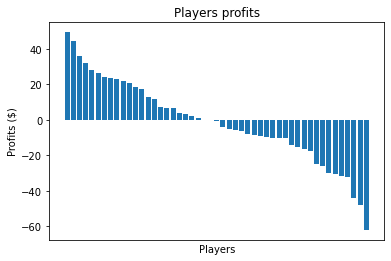

In [19]:
plt.bar(x=list(sorted_player_betting_dict.keys()), height=list(sorted_player_betting_dict.values()))
plt.title("Players profits")
plt.xlabel("Players")
plt.ylabel("Profits ($)")
plt.xticks([])
None

### Plot top 10 profitable kickers

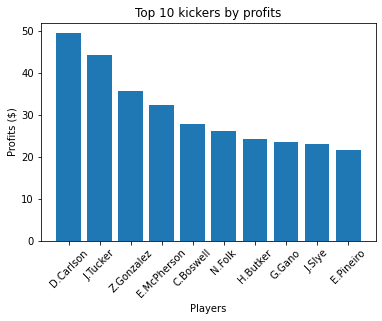

In [20]:
kicker_names = list(sorted_player_betting_dict.keys())
kicker_profits = list(sorted_player_betting_dict.values())

plt.bar(x=kicker_names[:10], height=kicker_profits[:10])
plt.title("Top 10 kickers by profits")
plt.xlabel("Players")
plt.ylabel("Profits ($)")
plt.xticks(rotation=45, fontsize=10)
None

### Plot bottom 10 profitable kickers

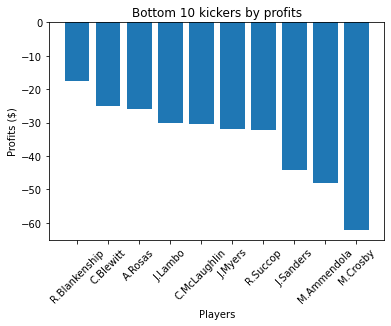

In [21]:
plt.bar(x=kicker_names[-10:], height=kicker_profits[-10:])
plt.title("Bottom 10 kickers by profits")
plt.xlabel("Players")
plt.ylabel("Profits ($)")
plt.xticks(rotation=45, fontsize=10)
None

### Divide payout by number of attempted kicks

In [22]:
player_betting_dict_per_kick = {}
for player in player_betting_dict.keys():
    player_df = df[df["player_name"] == player]
    player_df.reset_index(drop=False, inplace=True)
    
    kicks = 0
    for i in range(len(player_df)):
        made = len(player_df.loc[i, "fg_made_list"])
        missed = len(player_df.loc[i, "fg_missed_list"])
        kicks += made + missed
    
    if(kicks > 0):
        player_betting_dict_per_kick[player] = round(player_betting_dict[player]/kicks, 2)

sorted_player_betting_dict_per_kick = dict(sorted(player_betting_dict_per_kick.items(), key=lambda item: item[1], reverse=True))
sorted_player_betting_dict_per_kick

{'E.Pineiro': 2.71,
 'Z.Gonzalez': 1.7,
 'J.Tucker': 1.2,
 'D.Carlson': 1.05,
 'R.Patterson': 0.93,
 'J.Slye': 0.92,
 'C.Naggar': 0.91,
 'H.Butker': 0.73,
 'B.Johnson': 0.73,
 'E.McPherson': 0.72,
 'G.Gano': 0.71,
 'C.Boswell': 0.7,
 'N.Folk': 0.65,
 'Y.Koo': 0.61,
 'J.Elliott': 0.59,
 'M.Gay': 0.48,
 'R.Gould': 0.4,
 'A.Seibert': 0.28,
 'M.Wright': 0.27,
 'B.McManus': 0.23,
 'G.Joseph': 0.1,
 'D.Hopkins': 0.06,
 'B.Maher': -0.05,
 'C.Santos': -0.2,
 'G.Zuerlein': -0.25,
 'T.Bass': -0.3,
 'M.Prater': -0.41,
 'R.Bullock': -0.45,
 'M.Badgley': -0.48,
 'K.Fairbairn': -0.85,
 'T.Vizcaino': -0.89,
 'R.Succop': -0.95,
 'E.Fry': -1.04,
 'D.Eberle': -1.25,
 'R.Blankenship': -1.34,
 'J.Myers': -1.38,
 'C.McLaughlin': -1.52,
 'J.Sanders': -1.52,
 'L.Hajrullahu': -1.6,
 'R.Santoso': -1.71,
 'M.Crosby': -1.88,
 'M.Ammendola': -2.53,
 'A.Rosas': -5.16,
 'J.Lambo': -10.0,
 'M.Wishnowsky': -10.0,
 'B.Pinion': -10.0,
 'C.Blewitt': -12.53}

### Plot profits/kicks

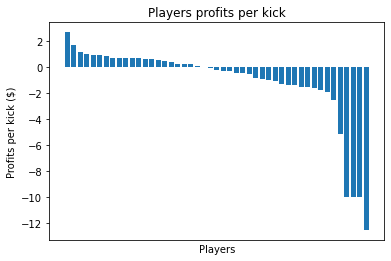

In [23]:
plt.bar(x=list(sorted_player_betting_dict_per_kick.keys()), height=list(sorted_player_betting_dict_per_kick.values()))
plt.title("Players profits per kick")
plt.xlabel("Players")
plt.ylabel("Profits per kick ($)")
plt.xticks([])
None

## set minimum attempts to 10

In [24]:
player_betting_dict_per_kick = {}
for player in player_betting_dict.keys():
    player_df = df[df["player_name"] == player]
    player_df.reset_index(drop=False, inplace=True)
    
    kicks = 0
    for i in range(len(player_df)):
        made = len(player_df.loc[i, "fg_made_list"])
        missed = len(player_df.loc[i, "fg_missed_list"])
        kicks += made + missed
    
    if(kicks > 10):
        player_betting_dict_per_kick[player] = round(player_betting_dict[player]/kicks, 2)

sorted_player_betting_dict_per_kick = dict(sorted(player_betting_dict_per_kick.items(), key=lambda item: item[1], reverse=True))
sorted_player_betting_dict_per_kick

{'Z.Gonzalez': 1.7,
 'J.Tucker': 1.2,
 'D.Carlson': 1.05,
 'R.Patterson': 0.93,
 'J.Slye': 0.92,
 'H.Butker': 0.73,
 'E.McPherson': 0.72,
 'G.Gano': 0.71,
 'C.Boswell': 0.7,
 'N.Folk': 0.65,
 'Y.Koo': 0.61,
 'J.Elliott': 0.59,
 'M.Gay': 0.48,
 'R.Gould': 0.4,
 'A.Seibert': 0.28,
 'M.Wright': 0.27,
 'B.McManus': 0.23,
 'G.Joseph': 0.1,
 'D.Hopkins': 0.06,
 'B.Maher': -0.05,
 'C.Santos': -0.2,
 'G.Zuerlein': -0.25,
 'T.Bass': -0.3,
 'M.Prater': -0.41,
 'R.Bullock': -0.45,
 'M.Badgley': -0.48,
 'K.Fairbairn': -0.85,
 'R.Succop': -0.95,
 'R.Blankenship': -1.34,
 'J.Myers': -1.38,
 'C.McLaughlin': -1.52,
 'J.Sanders': -1.52,
 'M.Crosby': -1.88,
 'M.Ammendola': -2.53}

### Plot profitability per kick (min 10 attempts)

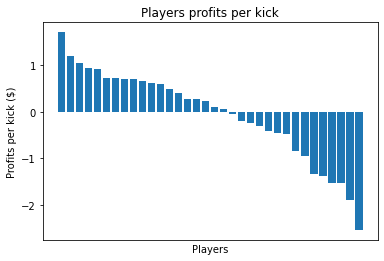

In [25]:
plt.bar(x=list(sorted_player_betting_dict_per_kick.keys()), height=list(sorted_player_betting_dict_per_kick.values()))
plt.title("Players profits per kick")
plt.xlabel("Players")
plt.ylabel("Profits per kick ($)")
plt.xticks([])
None

### Plot top 10 profitable players by kicks (10 kick min)

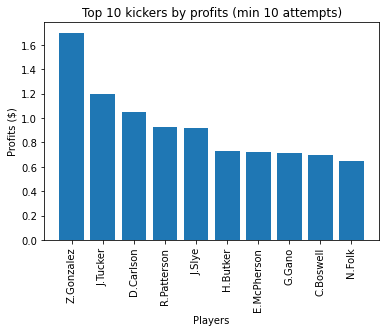

In [26]:
kicker_names_per_kick = list(sorted_player_betting_dict_per_kick.keys())
kicker_profits_per_kick = list(sorted_player_betting_dict_per_kick.values())

plt.bar(x=kicker_names_per_kick[:10], height=kicker_profits_per_kick[:10])
plt.title("Top 10 kickers by profits (min 10 attempts)")
plt.xlabel("Players")
plt.ylabel("Profits ($)")
plt.xticks(rotation=90, fontsize=10)
None

### Plot bottom 10 profitable players by kicks (10 kick min)

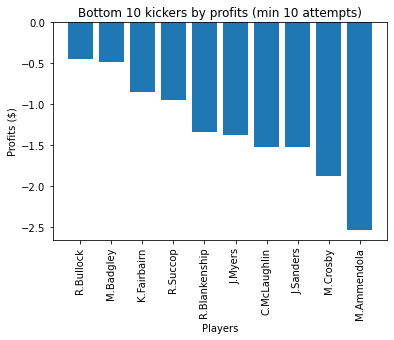

In [27]:
plt.bar(x=kicker_names_per_kick[-10:], height=kicker_profits_per_kick[-10:])
plt.title("Bottom 10 kickers by profits (min 10 attempts)")
plt.xlabel("Players")
plt.ylabel("Profits ($)")
plt.xticks(rotation=90, fontsize=10)
None